In [45]:

#import lightgbm
import random
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, KFold, TimeSeriesSplit
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정
#불러오기
merged_train_df = pd.read_csv('./data/train_preprocessed_lbw.csv')
merged_train_df.drop(columns=['Unnamed: 0'],inplace= True)
merged_test_df = pd.read_csv('./data/test_preprocessed_lbw.csv')
merged_test_df.drop(columns=['Unnamed: 0'],inplace= True)
merged_train_df.head()


,building_number,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,hour,day,...,ess_capacity,pcs_capacity,day_hour_mean,hour_mean,hour_std,CDH,holiday,sin_time,cos_time,THI
0,1,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,0,2,...,0.0,0.0,1774.744615,1706.318118,446.882767,-7.4,0,0.000000,1.000000,49.6576
1,1,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,1,2,...,0.0,0.0,1687.347692,1622.620235,439.662704,-15.4,0,0.258819,0.965926,47.7625
2,1,17.7,0.0,1.5,45.0,0.0,0.0,974.88,2,2,...,0.0,0.0,1571.483077,1506.971294,412.071906,-23.7,0,0.500000,0.866025,47.2225
3,1,16.7,0.0,1.4,48.0,0.0,0.0,953.76,3,2,...,0.0,0.0,1522.153846,1437.365647,391.205981,-33.0,0,0.707107,0.707107,44.7856
4,1,18.4,0.0,2.8,43.0,0.0,0.0,986.40,4,2,...,0.0,0.0,1506.793846,1447.321412,381.099697,-40.6,0,0.866025,0.500000,49.0061


In [46]:
merged_train_df = pd.read_csv('./data/train_preprocessed_lbw.csv')
# test = merged_train_df.loc[(merged_train_df['building_number'] == 22) &(merged_train_df['week'] == 22) & (merged_train_df['day']==2)]
# test['max'] = np.max(test['power_consumption'])
# test['max'] = np.min(test['power_consumption'])

In [47]:
def data(df):

    df['cooling_to_total_area_ratio'] =  df['cooling_area'] / df['total_area']
    
    grouped = df.groupby(['building_number', 'week', 'day'])

    df['max_power'] = grouped['power_consumption'].transform(np.max)
    df['min_power'] = grouped['power_consumption'].transform(np.min)
    
    grouped2 = df.groupby(['building_number', 'week', 'day','holiday'])

    df['max_power'] = grouped2['max_power'].transform(np.mean)
    df['min_power'] = grouped2['min_power'].transform(np.mean)

    df['solar_to_ess_ratio'] = df['solar_power_capacity'] / df['ess_capacity']
    #df['efficiency'] = df['pcs_capacity'] / df['power_consumption']
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0,inplace=True)
    ## StandardScaler 객체 생성
    #from sklearn.preprocessing import MinMaxScaler
    # scaler = MinMaxScaler()
    ## 데이터 표준화
    # df['solar_to_ess_ratio'] = scaler.fit_transform(df[['solar_to_ess_ratio']])
    # df['efficiency'] = scaler.fit_transform(df[['efficiency']])
    df.drop(columns=['Unnamed: 0','sunshine','pcs_capacity','ess_capacity','solar_power_capacity','solar_radiation','total_area','cooling_area'],inplace= True)
        
    return df

def data2(df):

    df['cooling_to_total_area_ratio'] =  df['cooling_area'] / df['total_area']
    
    grouped = merged_train_df.groupby(['building_number', 'holiday'])

    df['max_power'] = grouped['max_power'].transform(np.mean)
    df['min_power'] = grouped['min_power'].transform(np.mean)

    df['solar_to_ess_ratio'] = df['solar_power_capacity'] / df['ess_capacity']
    #df['efficiency'] = df['pcs_capacity'] / df['power_consumption']
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0,inplace=True)
    ## StandardScaler 객체 생성
    #from sklearn.preprocessing import MinMaxScaler
    # scaler = MinMaxScaler()
    ## 데이터 표준화
    # df['solar_to_ess_ratio'] = scaler.fit_transform(df[['solar_to_ess_ratio']])
    # df['efficiency'] = scaler.fit_transform(df[['efficiency']])
    df.drop(columns=['pcs_capacity','ess_capacity','solar_power_capacity','total_area','cooling_area'],inplace= True)
        
    return df

merged_train_df = data(merged_train_df)
merged_test_df = data2(merged_test_df)


best iterations: 725
SMAPE : 1.6817224771319226


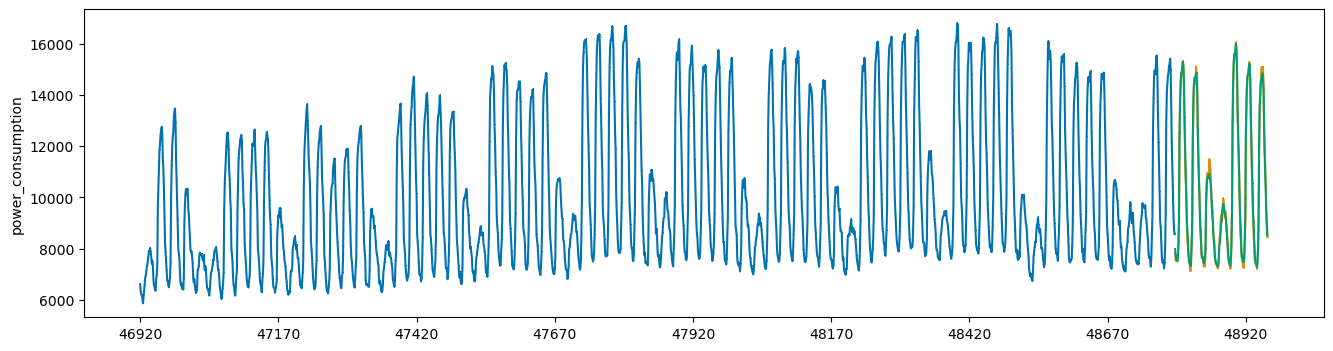

In [31]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

merged_train_df = data(merged_train_df)
## 54번 건물의 발전량
bnum = 24
y = merged_train_df.loc[merged_train_df.building_number == bnum, 'power_consumption']
x = merged_train_df.loc[merged_train_df.building_number == bnum, ].drop(columns=['power_consumption'])

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
## mse가중치 사용 O
xgb_params = pd.read_csv('./parameters/hyperparameter_xgb_final3_lbw.csv')

xgb_reg = XGBRegressor(n_estimators = 10000, eta = xgb_params.iloc[bnum-1,1], min_child_weight = xgb_params.iloc[bnum-1,2], 
                       max_depth = xgb_params.iloc[bnum-1,3], colsample_bytree = xgb_params.iloc[bnum-1,4], 
                       subsample = xgb_params.iloc[bnum-1,5], seed=0)
xgb_reg.set_params(**{'objective':weighted_mse(100)})
xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

Feature 0: 0.0
Feature 1: 0.00371735030785203
Feature 2: 0.00032475689658895135
Feature 3: 0.0010984535329043865
Feature 4: 0.0009887045016512275
Feature 5: 0.007179918698966503


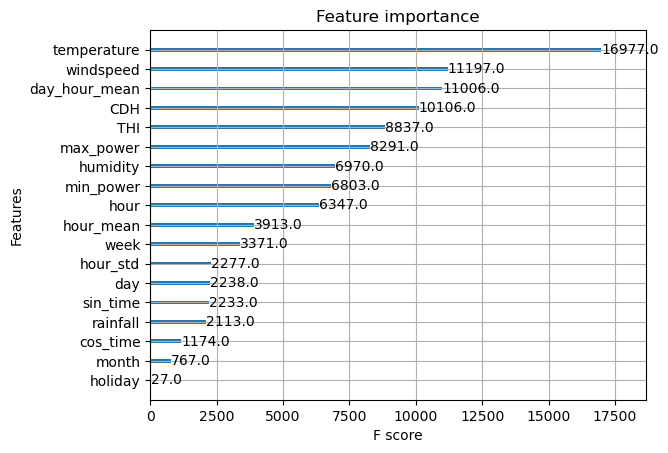

In [32]:
import xgboost as xgb
import matplotlib.pyplot as plt

# 피처 중요도 확인
feature_importances = xgb_reg.feature_importances_

# 피처 중요도를 출력합니다.(위에서 5개만)
for i, feat_importance in enumerate(feature_importances):
  if i <6:
    print(f"Feature {i}: {feat_importance}")

# 피처 중요도를 시각화합니다.
xgb.plot_importance(xgb_reg)
plt.show()

iterations: 가중치 편향 업데이트 횟수 오... 

best iterations: 625
SMAPE : 28.712065549182658


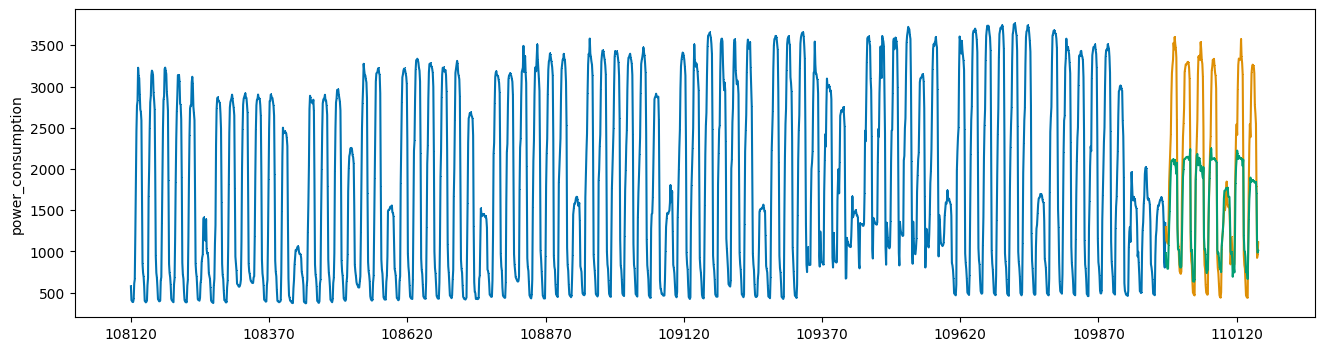

In [13]:
#추가 전처리
merged_train_df = data(merged_train_df)
merged_train_df['power_consumption'] = np.log1p(merged_train_df['power_consumption'])


def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


## 7번 건물의 발전량
bnum = 54
y = merged_train_df.loc[merged_train_df.building_number == bnum, 'power_consumption']
x = merged_train_df.loc[merged_train_df.building_number == bnum, ].drop(columns=['power_consumption'])

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
## mse가중치 사용 O
xgb_params = pd.read_csv('./parameters/hyperparameter_xgb2.csv')
xgb_params.drop(columns=['Unnamed: 0'],inplace= True)
xgb_reg = XGBRegressor(n_estimators = 10000, eta = xgb_params.iloc[bnum-1,1], min_child_weight = xgb_params.iloc[bnum-1,2], 
                       max_depth = xgb_params.iloc[bnum-1,3], colsample_bytree = xgb_params.iloc[bnum-1,4], 
                       subsample = xgb_params.iloc[bnum-1,5], seed=0)
xgb_reg.set_params(**{'objective':weighted_mse(100)})
xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)


y_train =np.expm1(y_train)
y_valid =np.expm1(y_valid)

pred = xgb_reg.predict(x_valid)
pred = np.expm1(pred)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))